In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
import torchvision.models as models

import time
import logging
import numpy as np
import pandas as pd
import os

from torch.nn import ReLU
import matplotlib.pyplot as plt

In [13]:
class DataSplit:
    """
    Replace DataLoader !
    Allows to triple Load the data into three differents sets : train, test and val
    The size of the datasets depends on the splits inputed as train_split, val_split and test_split
    It is possible to have the data randomly sampled with the argument shuffle = True
    """
    def __init__(self, dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False):
        """
        Initialize the data split based on the splits given in inputs
        Inputs : 
            - dataset : dataset loaded with torchivison.datasets.ImageFolder()
            - train_split, val_split and test_split : the size of the splits in % of the dataset size
            - shuffle : the possibility of sampling randomly through the dataset
        """
        self.dataset = dataset
        dataset_size = len(dataset)
        self.indices = list(range(dataset_size)) #all the indices
 
        #the quantity of data in each section of dataset
        train_split = int(np.floor(train_split * dataset_size))
        val_split = int(np.floor(val_split * dataset_size))
        #test split is what is left not sampled
        test_split = int(np.floor(dataset_size - train_split - val_split))
    
        if shuffle:
            np.random.shuffle(self.indices)
        
        self.train_indices = self.indices[:train_split]
        self.val_indices = self.indices[train_split : train_split+val_split]
        self.test_indices = self.indices[train_split + val_split :]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)


    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)


    def get_validation_split_point(self):
        return len(self.train_sampler)


    def get_split(self, batch_size=64, num_workers=4):
        print('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader


    def get_train_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing train dataloader')
        self.train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader


    def get_validation_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing validation dataloader')
        self.val_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader


    def get_test_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing test dataloader')
        self.test_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

In [8]:
normal_images = torchvision.datasets.ImageFolder(root=r"C:/Users/delpi/Mon Drive/COURS/AgroParisTech/3A IODAA/Fil rouge/CIRSE/data", transform=transforms.ToTensor())
B = DataSplit(normal_images, shuffle=True)

# Loading the data into three different sets
train = B.get_train_loader()
test = B.get_test_loader()
val = B.get_validation_loader()

In [ ]:
#loading the three models 
mod = models.resnet18(pretrained=True)
num_ftrs = mod.fc.in_features
mod.fc = nn.Linear(num_ftrs, 2)

mod_green = models.resnet18(pretrained=True)
num_ftrs_green = mod_green.fc.in_features
mod_green.fc = nn.Linear(num_ftrs, 2)

mod_skelet = models.resnet18(pretrained=True)
num_ftrs_skelet = mod_skelet.fc.in_features
mod_skelet.fc = nn.Linear(num_ftrs, 2)

/shared-libs/python3.9/py/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 320MB/s]


In [9]:
#la var str est le nom qu'on atribue les données générés par la pipeline
#contiennent cette var afin de les retrouver
normal = ("normal", mod, train, test, val)

#permet d'éviter de rentrer des tuples à la main
#Avec une boucle for on passe on passe automatiquement
#les tuples dans la pipeline
features = [normal]

NameError: name 'mod' is not defined

# Pipeline d'entrainement du modèle

In [10]:
class our_pipeline:
    def __init__(self,feature, num_epochs:int, early_stopping_threshold:int):
        
        self.net = feature[0]
        self.model = feature[1]
        self.train = feature[2]
        self.val = feature[3]
        self.test = feature[4]

        self.num_epochs = num_epochs
        self.early_stopping_threshold = early_stopping_threshold
        self.nb_class = len(self.train.dataset.classes)

        self.optimizer = Adam(self.model.parameters())
        #self.scheduler = CyclicLR(self.optimizer, base_lr=0.001, max_lr=0.01, step_size=10, mode='triangular')
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = StepLR(self.optimizer, step_size=10)

    def performances(self, data):

        #les métriques déjà programmées ne conviennent pas on crée les notres
        #Calcul de la sensibilité et de la spécificité
        nb_correct_pred = [0] * self.nb_class
        nb_total_pred = [0] * self.nb_class

        with torch.no_grad():
            for inputs, labels in data:
                outputs = self.model(inputs)
                #Sorti du model liste de proba d'appartenir à une classe
                #pred = argmax de la liste
                _, predicted = torch.max(outputs.data, 1)

                for i in range(len(labels)):
                    if labels[i] == predicted[i]:
                        nb_correct_pred[labels[i]] += 1
                    nb_total_pred[labels[i]] += 1
                
            self.good_pred = [nb_correct_pred[i] / nb_total_pred[i] for i in range(self.nb_class)]
        return self.good_pred

    def training(self):
        self.model.train()
        for inputs, labels in self.train:
            #réinitialisation du gradient
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

    def row(self, epoch):
        #Pour chaque epoch on veut avoir l'historique des performances sur train
        #et sur val ==> 1 ligne de data frame = perf d'1 epoch
        train_perf = self.performances(self.train)
        val_perf = self.performances(self.val)

        # balanced acc = (sepecificité + sensibilité)/2
        self.bal_acc_val = val_perf[0]+val_perf[1]/self.nb_class
        self.bal_acc_train = train_perf[0]+train_perf[1]/self.nb_class

        self.newrow = pd.DataFrame({'mod': [self.net], 'epoch': [epoch],
                            'true_neg_train':[train_perf[0]], 'true_pos_train':[train_perf[1]],
                            'true_neg_val':[val_perf[0]], 'true_pos_val':[val_perf[1]],
                            'balanced_acc_train': [self.bal_acc_train],
                            'balanced_acc_val': [self.bal_acc_val]
                            },index=[0])
        
        return self.newrow, self.bal_acc_val
        # on renvoi self.bal_acc_val car on s'en sert pour arrêter l'entrainement
        #En cas de surapprentissage

    def training_loop(self, print_res : bool):

        counter = 0
        best_acc = 0.0

        col_names = ['mod', 'epoch', 'true_neg_train', 'true_pos_train',
                        'true_neg_val', 'true_pos_val', 'balanced_acc_train',
                        'balanced_acc_val']

        stats = pd.DataFrame(columns=col_names)

        for epoch in range(self.num_epochs):
            self.training()
            perfs = self.row(epoch)
            if print_res : 
                print("state", self.net, ": ", epoch, "/", self.num_epochs)
                print(perfs[0])
            #A chaque époque on ajoute les stats
            stats = pd.concat([stats, perfs[0]])

            if perfs[1] > best_acc:
                best_acc = perfs[1]
                best_mod = self.model.state_dict()
                counter = 0
            else:
                counter += 1

            if counter >= self.early_stopping_threshold:
                if print_res : 
                    print("Early stopping at epoch: ", epoch+1)
                break
        #Sauvegarde du model avec l'heure
        now = time.time()
        mod_save_path = f"/work/{now}-Models_history/" + self.net + ".pt"
        torch.save(best_mod, mod_save_path)

        #Sauvegarde de l'historique avec l'heure
        stats_save_path = "/work/{now}-Models_history/" + self.net + ".csv"
        stats.to_csv(stats_save_path, index=False)

In [ ]:
for feature in tqdm (features, total = len(features)) :
    B = our_pipeline(feature, 200, 20)
    B.training_loop(print_res = True)

  0%|          | 0/1 [00:11<?, ?it/s]


KeyboardInterrupt: 

# Évaluation qualitative du modèle

In [11]:
def getSaliency(model,img,label):
    model.eval()
    #img = img.to(device)
    img.requires_grad = True    # ajout du gradient sur l'image elle-même
                                # idée: + gd gradient = + fort impact sur la décision
    img.grad = None
    outputs = nn.Softmax(dim=1)(model(img.unsqueeze(0)))    # ATTENTION, le softmax est dans la loss, pas dans le réseau 
                                                            # => il faut le remettre à la main pour que ça marche
    _, predicted = torch.max(outputs.data, 1)
    output=outputs[0,label]     # focalisation sur la vérité terrain
    output.backward()           # calcul des gradients associés à cette classe seulement
    sal=img.grad.abs()          # récupération du gradient sur l'image (+abs)
    if sal.dim()>2:
        sal=torch.max(sal,dim=0)[0]
    
    print("True label :", label.item(), "Predicted label : ", predicted.item())
    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img.detach().cpu().permute(1,2,0),cmap="gray")

    fig.add_subplot(1, 2, 2)
    plt.imshow(sal.to('cpu'),cmap="seismic",interpolation="bilinear")
    
    plt.show()

In [14]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load("normal.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

True label : 0 Predicted label :  0


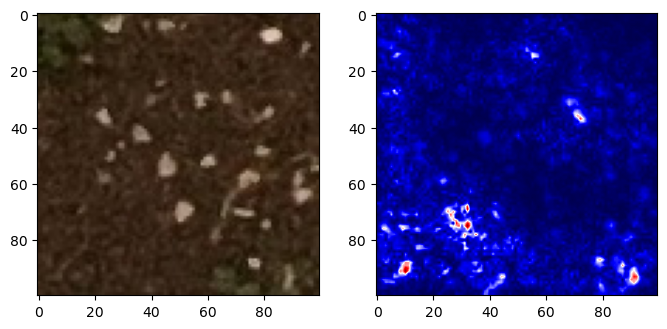

True label : 0 Predicted label :  0


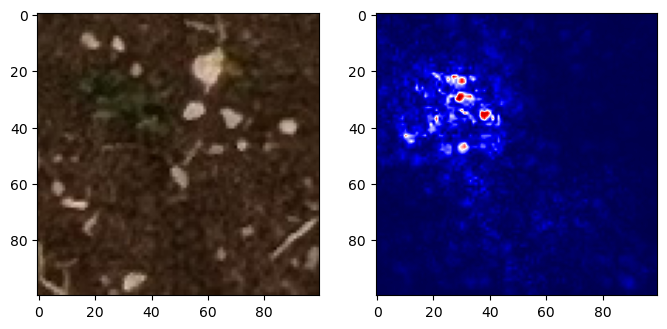

True label : 0 Predicted label :  0


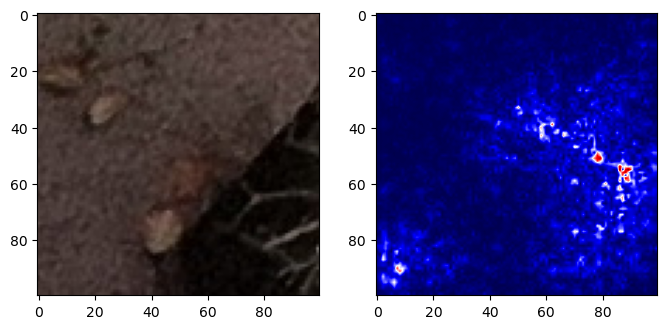

True label : 0 Predicted label :  0


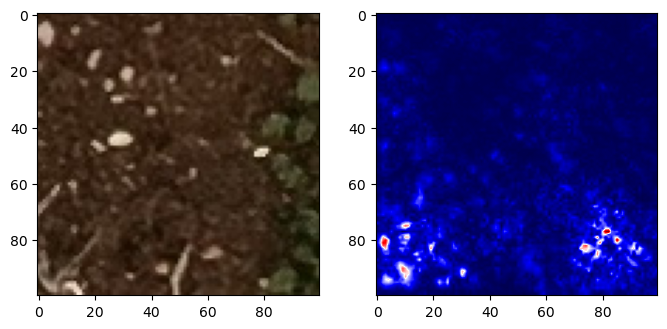

True label : 0 Predicted label :  0


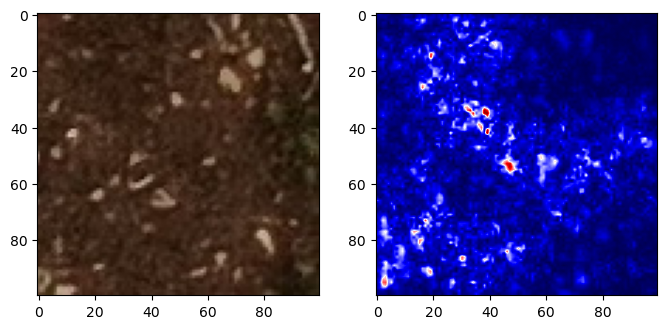

True label : 0 Predicted label :  0


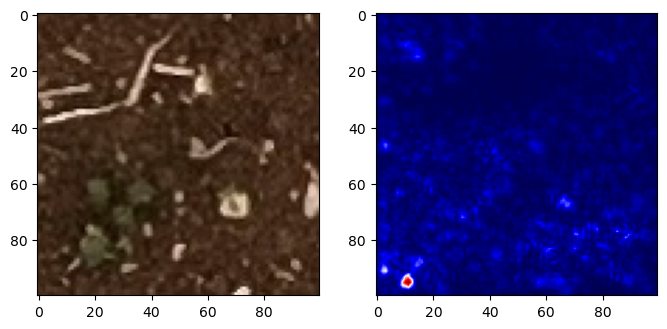

True label : 0 Predicted label :  0


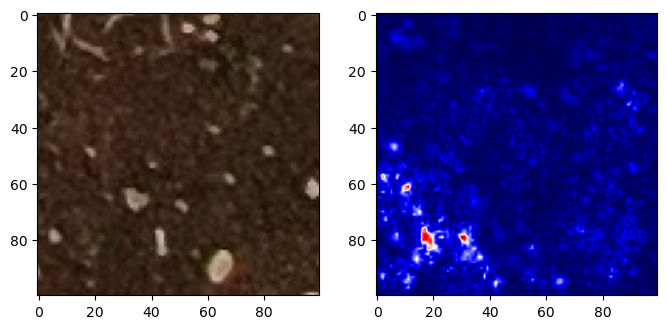

True label : 1 Predicted label :  1


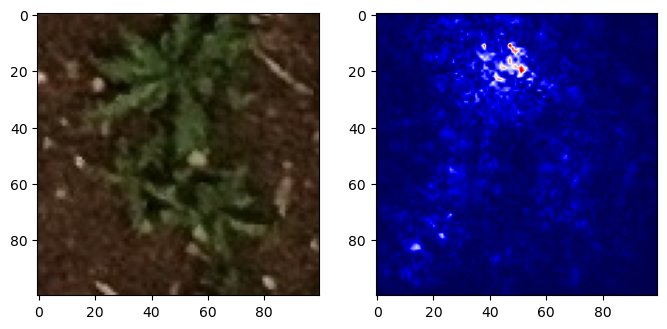

True label : 0 Predicted label :  0


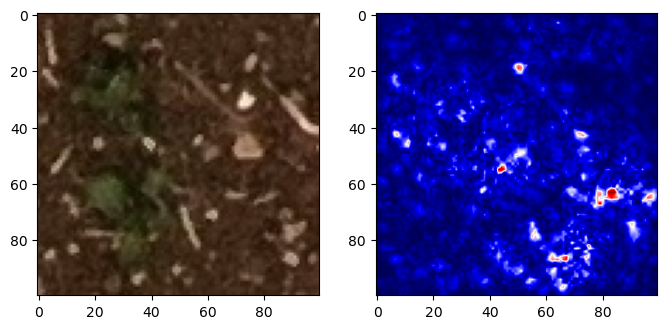

True label : 1 Predicted label :  1


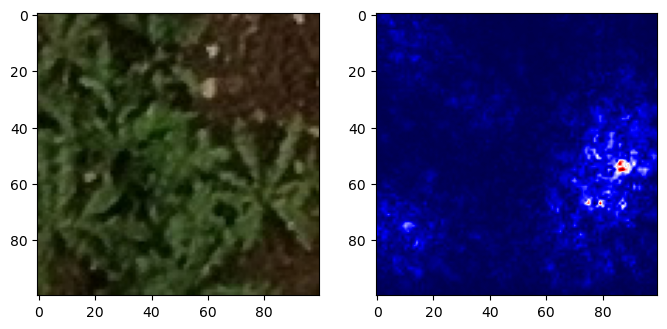

True label : 0 Predicted label :  0


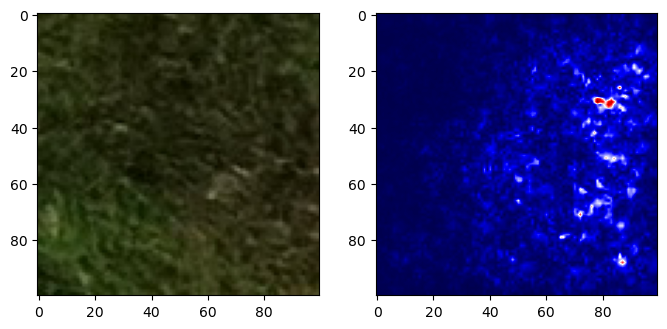

True label : 0 Predicted label :  0


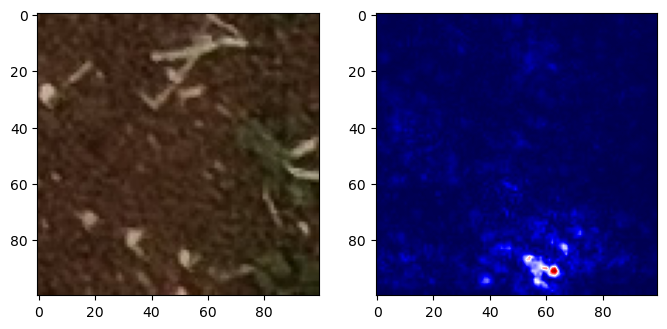

True label : 0 Predicted label :  0


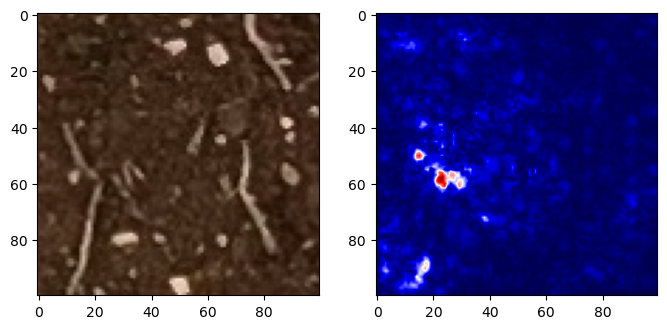

True label : 0 Predicted label :  0


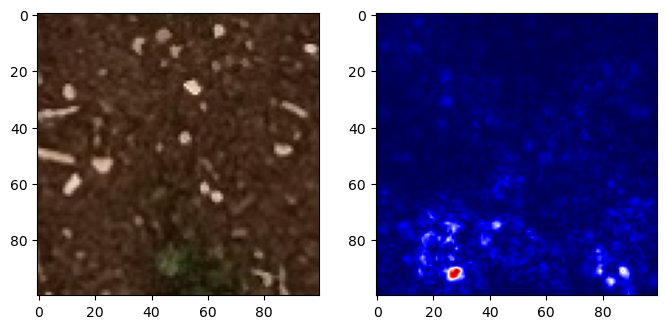

True label : 0 Predicted label :  0


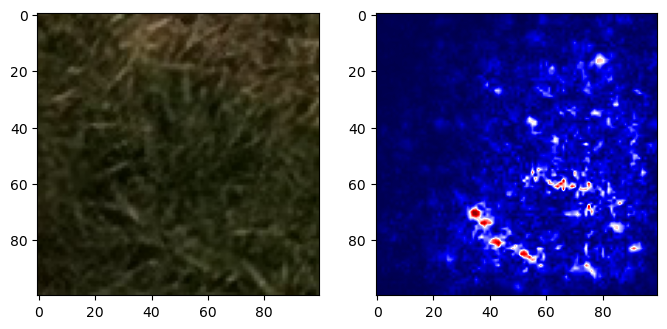

True label : 0 Predicted label :  0


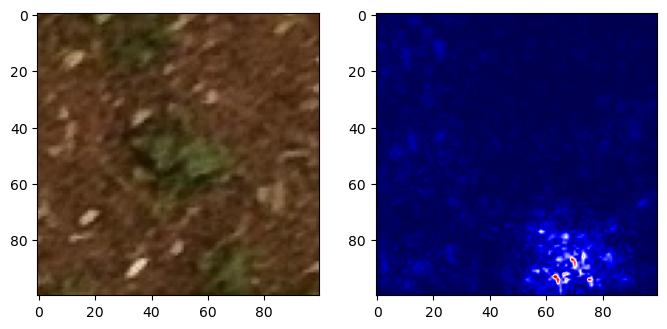

True label : 0 Predicted label :  0


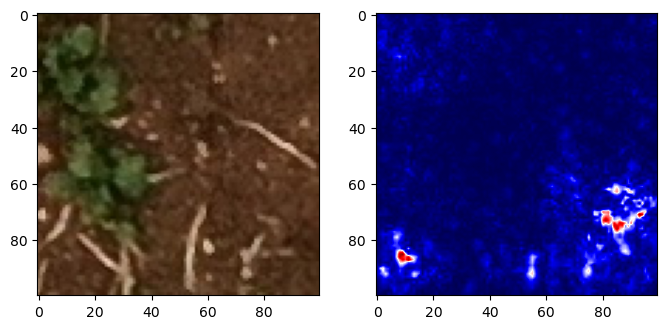

True label : 0 Predicted label :  0


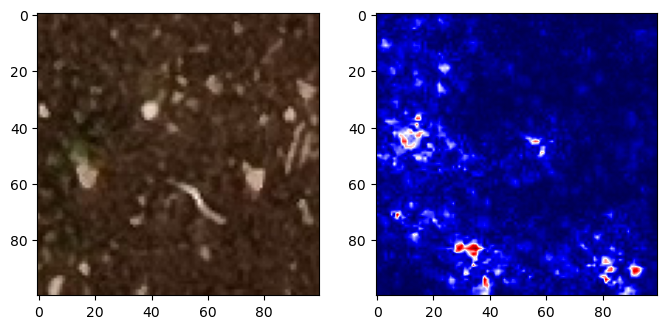

True label : 1 Predicted label :  1


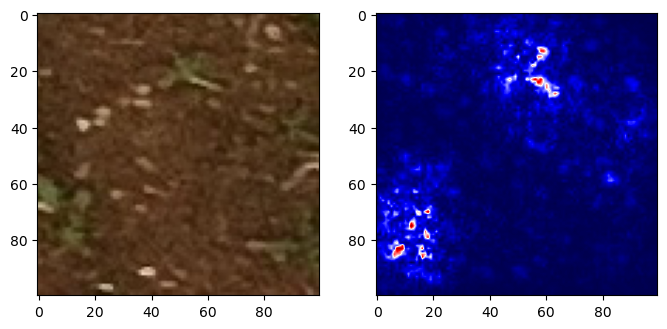

True label : 1 Predicted label :  1


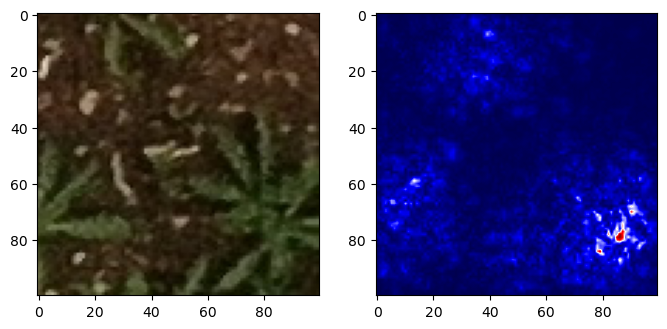

In [11]:
nb = 0
while nb < 20:
    for inputs, labels in val:
        for i in range(len(labels)):
            getSaliency(model,inputs[i],labels[i])
            nb += 1
            if nb == 20:
                break
        if nb == 20:
            break

In [15]:
from change_hue import change_hue
from subimage_creation import SubimageCreator
import cv2
from random import randint

In [61]:
def global_evaluation (img_path:str, model):
    compteur=0
    #Division de la grande image en sous-images
    sushi = SubimageCreator(img_path, size=(100, 100))
    sushi.cut()

    #Chaque sous-image passe par le model pour être classifiée
    for subimage in sushi.subimages:
        img = cv2.imread(sushi.output_dir+"/"+subimage)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(img)
        img= img.unsqueeze(0)
        img = img.permute(0,3,1,2)
        img=img/255
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        
        #S'il y a un cirse sur l'imagette
        #on la colore en rouge, sinon
        #on la colore en vert
        if predicted == 0:
            col = 60
        else:
            col = 0
            compteur+=1
            
        path=sushi.output_dir+"/"+subimage
        img = cv2.imread(path)
        image_hued=change_hue(img,col)
        cv2.imwrite(sushi.output_dir+"/"+"hued_"+subimage,image_hued)
    sushi.rebuild("hued_")
    print(f"on a {compteur} trucs positifs")

In [62]:
path = "DJI_0202.JPG"
global_evaluation(path, model)

1200
(3000, 4000, 3)
Rebuilt an image of size (3000, 4000, 3) from an image of size (3000, 4000, 3) and subimages of size (100, 100)
on a 187 trucs positifs


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6f211ba4-8439-4b4f-a72d-48759d094385' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>